# Explore variant/phenotype data

Now that the very large variant data table has been processed, we can start looking at the data and the phenotype information.

Each variant contains the family in which it was identified, so we can link the variants back to those families with a history of recurrent miscarriages

Summary of variant processing so far:

 * Removed all variants with >5% allele frequency on GnomAD
 * Removed all syonymous and other non-proteint altering variants (except for +-1/2 splice variants)
 * ...

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import seaborn as sns
import sys
import scipy.stats as stats
# use seaborn plot styles
sns.set()

# increase max columns so we can see everything.
# Jupyter is nice in that it puts the table into a scrolling window
pd.set_option('display.max_columns', None)
# Set the max rows so we can easily see both head() and tail() of the dataframes
#pd.options.display.max_rows=10
pd.set_option('display.max_rows', 10)

# use this to hide the red warning boxes
# Only use once you know they aren't significant
import warnings
warnings.filterwarnings('ignore')

Processing the entire dataset can be very slow, so if it's already been done just load the stored data `variant_phenotype_merged.pickle`. Otherwise, we will have to generate this dataframe - `df_joined`.

Using the outputs of previous steps, `variants_processed_with_zscore.pickle` and `phenotypes_processed.pickle`, and combined dataframe is produced which maps each variant in each sample to the variant information (e.g. GnomAD frequency) for that variant. This adds a lot of duplication, but means that you can view at a glance all the information about a variant in a sample.

In [2]:
try:
    # We only want to reprocess the whole thing if the output csv isn't present
    df_joined = pd.read_pickle('Processed_data/variant_phenotype_merged.pickle')
except FileNotFoundError:
    ## Read in the two processed data csvs
    df_vars = pd.read_pickle("../05_Filter_variant_data/Processed_data/variants_processed_with_zscore.pickle")
    df_pheno = pd.read_pickle("../06_Process_phenotype_data/Processed_data/phenotypes_processed.pickle")

    # Merge the dataframes on proband ID, as this is guaranteed to be unique (I hope!)
    # Set the name for the join index column to be the same in both
    df_pheno = df_pheno.rename(columns={'proband_stable_id': 'PRO_ID'})
    df_joined = pd.merge(df_vars, df_pheno, on='PRO_ID')
    
    print("Length including duplicates: {} variants".format(df_joined.shape[0]))
    # remove duplicate samples (i.e. where a maternal sample is included from multiple probands)
    df_joined = df_joined[df_joined.duplicated(['MAT_ID', 'POS']) == False]
    print("Length with duplicates removed: {} variants".format(df_joined.shape[0]))
    
    # Now the data has been combined we can write it to a file
    # NOTE: This is really not all that efficient, there's a lot of data being duplicated. ? How to get around that?
    #       It's probably best to keep the two dfs separate and reference between them as needed?
    df_joined.to_pickle('Processed_data/variant_phenotype_merged.pickle')

### Identifying genes with more than expected number of recurrent pregnancy losses

* Some women will have had recurrent miscarriages for other reasons, so they are not all linked to maternal effect genes.
* We expect that maternal effect genes may result in a higher risk of miscarriage.
* These genes may result in a higher number of observed miscarriages.
* These genes may have more women with recurrent miscarriages than non maternal-effect genes.

* We can work out the rate of recurrent miscarriages for each gene
* This will produce a range, hopefully normally distributed
* We can then identify those genes that fall at the extremes of this distribution and investigate them further.

In [3]:
# what is the ratio of 3+ to (None + 2) pregnancy_loss_history

# This is VERY slow on larger dataframes!
# So if the pre-processed file exists, load that instead
try:
    df_genes = pd.read_pickle('Processed_data/per_gene_pregnancy_loss_ratio.pickle')
except FileNotFoundError:
    df_ratio = pd.DataFrame(index=['loss_frequency', 'losses', 'count', 'mat_loss_frequency', 'mat_losses', 'mat_count', 'pat_loss_frequency', 'pat_losses', 'pat_count'])

    for gene in list(df_joined.GENE.unique()):
        # Get the number of losses/non losses when the variant is present in *any* parent
        try:
            losses = df_joined[df_joined.GENE == gene].pregnancy_loss_history.value_counts()['3+']
        except KeyError:
            losses = 0
        total = df_joined[df_joined.GENE == gene].pregnancy_loss_history.count()
        # Now add to the dataframe
        # Need to create each gene before we can access specific fields
        # So fill it with NaN so it's obvious if it hasn't been overwritten
        df_ratio[gene]  = pd.np.nan
        df_ratio[gene]['loss_frequency'] = (losses/total)
        df_ratio[gene]['losses'] = losses
        df_ratio[gene]['count'] = total

        # Get the count of losses and total when the variant is present in the mother
        try:
            mat_losses = df_joined[(df_joined.GENE == gene) & (df_joined.MAT_GT != 0)].pregnancy_loss_history.value_counts()['3+']
        except KeyError:
            mat_losses = 0
        mat_count = df_joined[(df_joined.GENE == gene) & (df_joined.MAT_GT != 0)].pregnancy_loss_history.count()
        # Now add to the dataframe
        df_ratio[gene]['mat_loss_frequency'] = (mat_losses/mat_count)
        df_ratio[gene]['mat_losses'] = mat_losses
        df_ratio[gene]['mat_count'] = mat_count

        # Now do the same for variants present in the father
        try:
            pat_losses = df_joined[(df_joined.GENE == gene) & (df_joined.PAT_GT != 0)].pregnancy_loss_history.value_counts()['3+']
        except KeyError:
            pat_losses = 0
        pat_count = df_joined[(df_joined.GENE == gene) & (df_joined.PAT_GT != 0)].pregnancy_loss_history.count()

        # For some reason, if you explicitly specify the 'ratio' column here it fails
        # but it works if you just let it sort it out itself.
        df_ratio[gene]['pat_loss_frequency'] = (pat_losses/pat_count)
        df_ratio[gene]['pat_losses'] = pat_losses
        df_ratio[gene]['pat_count'] = pat_count
        df_genes = df_ratio.transpose()
        df_genes.to_pickle("Processed_data/per_gene_pregnancy_loss_ratio.pickle")
    
# DEV: restrict to just genes with a good number of variants
#      50 is a fairly arbitrary selection
df_genes = df_genes[df_genes['count'] >= 50]

**NOTE:** The 'pregnancy loss percentage' for a gene is the percentage of cases with at least one variant in that gene that have had 3+ miscarriages, out of the total number of cases with at least one variant in that gene. It is anticipated that some genes (potentially including maternal effect genes) will have a higher percentage of pregnancy losses than might be expected.

<IPython.core.display.Javascript object>


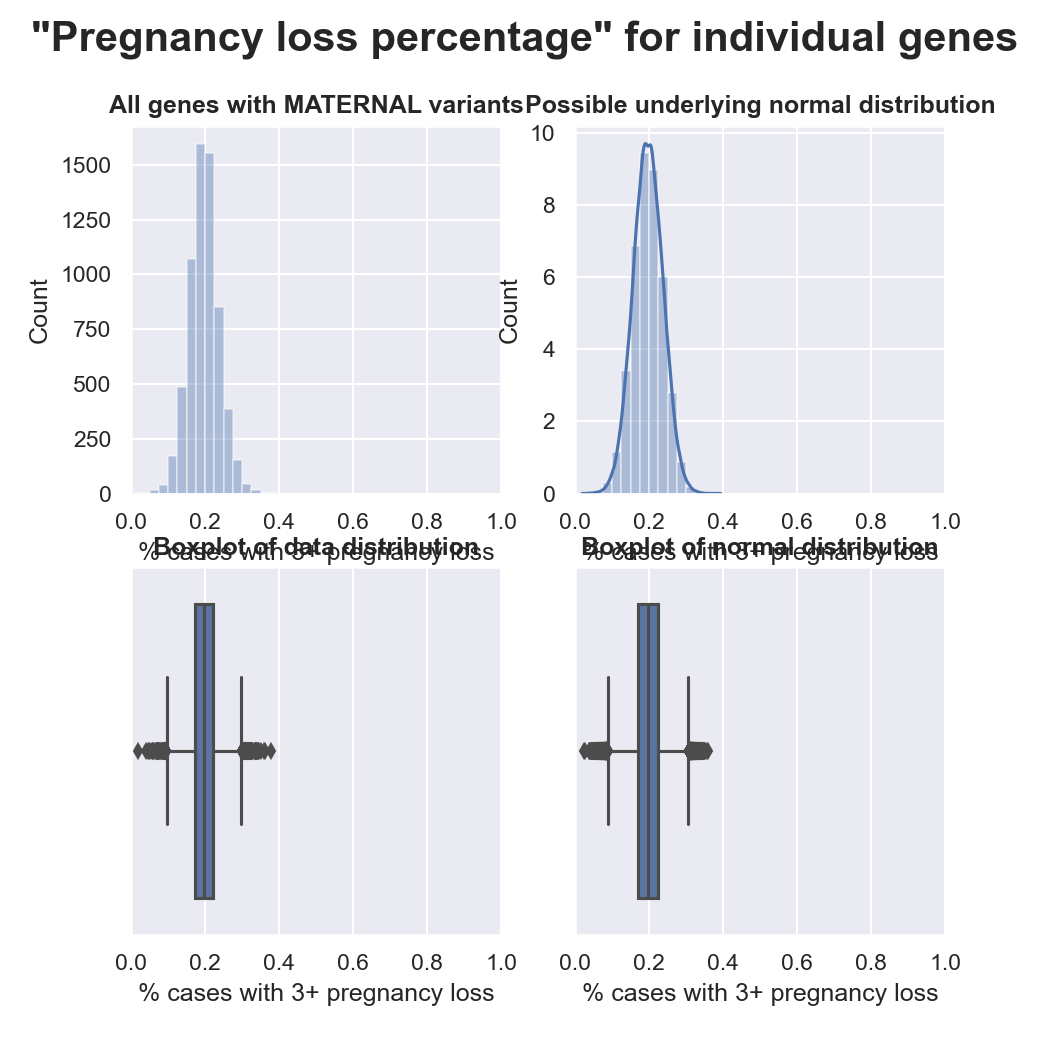

In [4]:
f, axes = plt.subplots(2, 2, figsize=(7, 7))
f.suptitle(
    '"Pregnancy loss percentage" for individual genes',
    fontweight='bold',
    fontsize=20)

# Plot histogram of the actual data
ax = sns.distplot(
    df_genes.mat_loss_frequency,
    ax=axes[0,0],
    kde=False,
    norm_hist=False,
    bins=np.arange(0,1,0.025))
ax.set_title("All genes with MATERNAL variants", fontweight='bold')
ax.set_ylabel("Count")
ax.set_xlabel("% cases with 3+ pregnancy loss")
ax.set_xlim(0,1)

# Plot the normal distribution with the same paramaters as the data
ax2 = sns.distplot(
    np.random.normal(
        loc=df_genes.describe()['mat_loss_frequency']['mean'],
        scale=df_genes.describe()['mat_loss_frequency']['std'],
        size=100000),
    ax=axes[0,1],
    kde=True,
    norm_hist=False,
    bins=np.arange(0,1,0.025))
ax2.set_title("Possible underlying normal distribution", fontweight='bold')
ax2.set_ylabel("Count")
ax2.set_xlabel("% cases with 3+ pregnancy loss")
ax2.set_xlim(0,1)

# Make a boxplot of the data distribution, just to highlight
# the bulk of the data, and outliers, etc.
ax3 = sns.boxplot(
    df_genes.mat_loss_frequency,
    ax=axes[1,0])
ax3.set_title("Boxplot of data distribution", fontweight='bold')
ax3.set_xlabel("% cases with 3+ pregnancy loss")
ax3.set_xlim(0,1)

# Do the same with the normal distribution, to show how similar they are
ax3 = sns.boxplot(
    np.random.normal(
        loc=df_genes.describe()['mat_loss_frequency']['mean'],
        scale=df_genes.describe()['mat_loss_frequency']['std'],
        size=100000),
    ax=axes[1,1])
ax3.set_title("Boxplot of normal distribution", fontweight='bold')
ax3.set_xlabel("% cases with 3+ pregnancy loss")
ax3.set_xlim(0,1)

# Hide some annoying jupyter output
print("")

In [5]:
#TODO: Can we add a QQ plot here to confirm the distribution?

The above plots show the distribution of genes ordered by the frequency of recurrent pregnancy loss seen in samples with variants in that gene.

For example, variants in gene *EXAMPLE1* are seen in 10 samples. Of these, 3 have had more than 3 miscarriages. The pregnancy loss frequency for *EXAMPLE1* is therefore 0.3 (30%).

The histograms summarise the number of genes falling around frequency ranges. As this is done on *all* variants, the majority of which will have no effect on pregnancy loss, it should provide some indication of the normal frequency of pregnancy loss (i.e. independent of a specific genetic variant). Selecting variants that have higher than expected loss frequencies might identify causative variants.

By assuming a normal distribution - which this data appears to be close to (the top right plot is random normally distributed data using the mean and standard deviation of this data) - we can estimate the likelihood that a gene would have an unusual number of pregnancy losses by chance.

### Select outlying genes

We want to select the genes that fall in the extremes of this distribution of expected recurrent pregnancy losses (i.e. those genes were the % of cases with 3+ losses is much higher than the overall average). To keep this as simple as possible, we are assuming that the correct distribution is that shown in the 3rd histogram above. That is, it ignores the highest percentages - assuming that they are skewed by genes with only a few samples with variants - and the same for those genes with no pregnancy losses.

As shown above, this indicates an approximately normal distribution with a mean of ~0.2 and a standard deviation of ~0.1. For a normal distribution, 99% of values are expected to fall within 3 standard deviations of the mean.

In [6]:
# Show max of 10 rows - was having issues coming back from the bottom of the page, where this is set to show all
pd.set_option('display.max_rows', 10)

# to test this, let's count the genes 

# How many genes are there?
genecount = df_genes.shape[0]

# Get the basic info about the distribution of the data
dist_info = df_genes[(df_genes.mat_loss_frequency != 0)].describe()

# how many standard deviations away do we want to start?
standarddeviations = 3

# Extract the genes were the loss frequency is >3 standard deviations above the mean.
allgeneshigh = df_genes[df_genes.mat_loss_frequency > float(dist_info.loc['mean'].mat_loss_frequency)  + float(dist_info.loc['std'].mat_loss_frequency) * standarddeviations]

pat_dist_info = df_genes[(df_genes.pat_loss_frequency != 0)].describe()
pat_allgeneshigh = df_genes[df_genes.pat_loss_frequency > float(dist_info.loc['mean'].pat_loss_frequency)  + float(dist_info.loc['std'].pat_loss_frequency) * standarddeviations]


# It's a bit annoying that I can't put these into markup - it can't handle variables so I have to use a print.
print("{:.2f}% of genes are above 3 standard deviations from the mean".format((allgeneshigh.shape[0] / genecount)*100))
print("Genes above cutoff: {}".format(allgeneshigh.shape[0]))

0.52% of genes are above 3 standard deviations from the mean
Genes above cutoff: 33


<1% of the genes are above the 3 std cutoff, which is close to the expected numbers. However we'd expect a bit of skewing as the data has a fundamentally uneven distribution - the highest possible value is much further from the mean than the lowest (i.e. you can't have a negative percentage here). Plus there will likely be other confounding factors that are also affecting the miscarriage rate in some patients, which particularly might effect those genes with very few variants.

In [7]:
allgeneshigh.sort_values("mat_loss_frequency", ascending=False)

loss_frequency  losses  count  mat_loss_frequency  mat_losses  \
BBS4           0.377358    20.0   53.0            0.377358        20.0   
DSPP           0.362069    21.0   58.0            0.362069        21.0   
PYROXD2        0.360000    18.0   50.0            0.360000        18.0   
CCAR2          0.351852    19.0   54.0            0.351852        19.0   
PRUNE          0.346667    26.0   75.0            0.346667        26.0   
...                 ...     ...    ...                 ...         ...   
ZNF224         0.322034    19.0   59.0            0.322034        19.0   
SOS2           0.320755    34.0  106.0            0.320755        34.0   
ALDH3A2        0.320755    17.0   53.0            0.320755        17.0   
ELF3           0.320000    16.0   50.0            0.320000        16.0   
NGF            0.320000    16.0   50.0            0.320000        16.0   

         mat_count  pat_loss_frequency  pat_losses  pat_count  
BBS4          53.0            0.377358        20.0       53.0  
DSPP          58.0            0.362069        21.0       58.0  
PYROXD2       50.0            0.360000        18.0       50.0  
CCAR2         54.0            0.351852        19.0       54.0  
PRUNE         75.0            0.346667        26.0       75.0  
...            ...                 ...         ...        ...  
ZNF224        59.0            0.322034        19.0       59.0  
SOS2         106.0            0.320755        34.0      106.0  
ALDH3A2       53.0            0.320755        17.0       53.0  
ELF3          50.0            0.320000        16.0       50.0  
NGF           50.0            0.320000        16.0       50.0  

[33 rows x 9 columns]

To compare, this is the list as sorted by the paternal loss frequency - the frequency of recurrent pregnancy loss when there is a variant in the gene in the father (NOTE: there may also be a variant in the mother, this does not require the variant to be exclusive to either parent)

In [8]:
pat_allgeneshigh.sort_values("pat_loss_frequency", ascending=False)

loss_frequency  losses  count  mat_loss_frequency  mat_losses  \
BBS4           0.377358    20.0   53.0            0.377358        20.0   
DSPP           0.362069    21.0   58.0            0.362069        21.0   
PYROXD2        0.360000    18.0   50.0            0.360000        18.0   
CCAR2          0.351852    19.0   54.0            0.351852        19.0   
PRUNE          0.346667    26.0   75.0            0.346667        26.0   
...                 ...     ...    ...                 ...         ...   
ZNF224         0.322034    19.0   59.0            0.322034        19.0   
SOS2           0.320755    34.0  106.0            0.320755        34.0   
ALDH3A2        0.320755    17.0   53.0            0.320755        17.0   
ELF3           0.320000    16.0   50.0            0.320000        16.0   
NGF            0.320000    16.0   50.0            0.320000        16.0   

         mat_count  pat_loss_frequency  pat_losses  pat_count  
BBS4          53.0            0.377358        20.0       53.0  
DSPP          58.0            0.362069        21.0       58.0  
PYROXD2       50.0            0.360000        18.0       50.0  
CCAR2         54.0            0.351852        19.0       54.0  
PRUNE         75.0            0.346667        26.0       75.0  
...            ...                 ...         ...        ...  
ZNF224        59.0            0.322034        19.0       59.0  
SOS2         106.0            0.320755        34.0      106.0  
ALDH3A2       53.0            0.320755        17.0       53.0  
ELF3          50.0            0.320000        16.0       50.0  
NGF           50.0            0.320000        16.0       50.0  

[34 rows x 9 columns]

In [9]:
# Are there any genes which are in BOTH groups?
shared_genes = [x for x in allgeneshigh.index.to_list() if x in pat_allgeneshigh.index.to_list()]

print("There are {} genes in both maternal and paternal lists.".format(len(shared_genes)))

There are 33 genes in both maternal and paternal lists.


### Are any maternal effect genes in this recurrent pregnancy loss group?

There is a list of potential maternal effect genes from Deborah, defined in the `genes` list. This is used to filter the joined dataframe to just these genes, and stored in the dataframe `df_mat`.

* i.e. the genes which higher than expected rates of multiple losses

To start off, are any in the >3std group? (>99% of the whole set)

In [10]:
# Define the maternal effect genes list
genes=["NLRP5","PADI6","NLRP14","DNMT1","TLE6","AKAP9","UHRF1","NLRP4","RDX","EEF1A1","ARHGEF2","NLRP7",
       "PYDC2","NLRP2","YWHAZ","DDB1","RHPN2","OOEP","USP9X","NLRP4","YWHAG","DDX6","YWHAH","YWHAQ","NLRP4",
       "YWHAE","DDX19A","DNMT1","ZAR1","DDX3X","DDX3Y","NLRP4","PDIA6","CDC42","CDCA2","CDK19","CDK5","MSN",
       "NLRP9"]

In [11]:
geneextremelyhigh = [gene for gene in df_genes[df_genes.loss_frequency >= float(dist_info.loc['mean'].loss_frequency) + float(dist_info.loc['std'].loss_frequency) * 3].index if gene in genes]

for gene in geneextremelyhigh:
    print(gene)

CDCA2


If we lower the cutoff to >2std (>95%) do we get many more?

In [12]:
geneveryhigh = [gene for gene in df_genes[df_genes.loss_frequency >= float(dist_info.loc['mean'].loss_frequency) + float(dist_info.loc['std'].loss_frequency) * 2].index if gene in genes]

for gene in geneveryhigh:
    print(gene)

NLRP5
CDCA2


How about just 1 std deviation from the mean (>68%)?

In [13]:
genehigh = [gene for gene in df_genes[df_genes.loss_frequency >= float(dist_info.loc['mean'].loss_frequency) + float(dist_info.loc['std'].loss_frequency)].index if gene in genes]

for gene in genehigh:
    print(gene)

NLRP5
CDCA2


Finally, what if we look at anything with greater than the average percentage of pregnancy losses?

In [14]:
genemean = [gene for gene in df_genes[df_genes.loss_frequency >= float(dist_info.loc['mean'].loss_frequency)].index if gene in genes]

for gene in genemean:
    print(gene)

AKAP9
NLRP5
CDCA2


The rest of the list should be below the mean

In [15]:
genelow = [gene for gene in df_genes[df_genes.loss_frequency < float(dist_info.loc['mean'].loss_frequency)].index if gene in genes]

for gene in genelow:
    print(gene)

PDIA6
NLRP4
DNMT1
NLRP2
NLRP14
NLRP7
RHPN2
NLRP9


The missing genes from the list can be accounted for as they did not have enough variants to be informative.

There are very few genes with an extremely high rate of recurrent pregnancy loss. This isn't hugely surprising given the data is from the DDD project, which was recruited from children with developmental disorders - therefore requiring the parents to have had at least one successful pregnancy. This means we lose two main classes of variant - those that render the carrier effectively infertile, and those which reduce fertility but result in normal offspring (**NOTE:** that's not to say that genes identified here produce *abnormal* children - the developmental phenotype may well be unrelated).

Interestingly, some of the genes that might be expected to have a significant effect (e.g. DNMT1A DNA methyltransferase) are found with a lower rate of recurrent miscarriage than might be expected.

## Variant level information

We want to take a look at the variants in these significant genes. To do this, we must add some additional information, and then we will use a drop-down menu to select the variant of interest. This will then show phenotype information from all samples in which the variant was found.

In [16]:
# Select the mat effect genes (i.e. in list "genes") that are in the genehigh list of genes > n SDs from the mean.
df_variants = df_joined[df_joined.GENE.isin(allgeneshigh.index.to_list())]

In [17]:
# Define functions to process this data (as it's the smallest we're likely to get this dataframe)
def extract_score(value):
    try:
        return value.rstrip(")").split("(")[1]
    except (AttributeError, IndexError):
        return pd.np.nan
    
def extract_annotation(value):
    try:
        return value.split("(")[0]
    except (AttributeError, IndexError):
        return pd.np.nan
    
def extract_ENST(value):
    try:
        return value.split(":")[0]
    except (AttributeError, IndexError):
        return pd.np.nan
    
def extract_HGVS(value):
    try:
        return value.split(":")[1]
    except (AttributeError, IndexError):
        return pd.np.nan


def get_ref(value):
    """Get reference bases from the ID <chr>:<pos><ref>><alt> description"""
    pos = []
    ref = []
    for char in value.split(":")[1].split(">")[0]:
        try:
            int(char)
            pos.append(char)    
        except ValueError:
            ref.append(char)

    pos = "".join(pos)
    ref = "".join(ref)
    
    return ref

def get_alt(value):
    """Get alt bases from the ID <chr>:<pos><ref>><alt> description"""
    return value.split(">")[1]

#def grantham_score(aa1: str, aa2: str) -> int:
def grantham_score(HGVSp):
    """Get the grantham distance between two amino acids"""
    # Get the AAs from the HGVSp
    try:
        aa1, aa2 = extract_aminos(HGVSp) 
    except TypeError:
        #print("ERROR: Did not get a tuple", file=sys.stderr)
        return pd.np.nan
    aa1 = aa_oneletter(aa1)
    aa2 = aa_oneletter(aa2)
    
    # Load the data if it isn't already in a dataframe
    try:
        df_grantham[aa1][aa2]
    except (AttributeError, NameError, UnboundLocalError):
        df_grantham = pd.read_csv("Data/grantham.tsv", sep="\t")
        df_grantham = df_grantham.set_index('FIRST')

    try:
        # "S" isn't in one axis for some reason (I didn't make this table!), so it will raise a KeyError
        # if passed to that axis. In that case, swap the keys around and it should work.
        score = df_grantham[aa1][aa2]
        # The score matrix is set up only half filled, so some combinations will return zero when they
        # shouldn't. If they do raise and capture an exception so that the keys will be swapped around.
        # This should then return the correct value.
        if score == 0:
            raise ValueError
    except (KeyError, ValueError, TypeError):
        try:
            score = df_grantham[aa2][aa1]
        except (KeyError, TypeError):
            #print("ERROR: Codon not recognised. ({}>{})".format(aa1, aa2), file=sys.stderr)
            return pd.np.nan
    return int(score)

def extract_aminos(HGVSp):
    """
    Extract amino acids from the HGVSp nomenclature (which uses 3-letter codes)
    "p.Arg14Gly"
    """
    try:
        return HGVSp.split(".")[1][:3], HGVSp.split(".")[1][-3:]
    except:
        #print("INFO: An error occured parsing HGPSp {}".format(HGVSp), file=sys.stderr)
        return pd.np.nan

def aa_oneletter(codon):
    lookup = {"Ala": "A", "Arg": "R", "Asn": "N", "Asp": "D", "Cys": "C",
              "Glu": "E", "Gln": "Q", "Gly": "G", "His": "H", "Ile": "I",
              "Leu": "L", "Lys": "K", "Met": "M", "Phe": "F", "Pro": "P",
              "Ser": "S", "Thr": "T", "Trp": "W", "Tyr": "Y", "Val": "V"}
    try:
        return lookup[codon]
    except KeyError:
        #print("ERROR: Codon not recognised. ({})".format(codon), file=sys.stderr)
        return pd.np.nan
    
def get_AC(var):
    try:
        return df_variants.groupby("ID")['MAT_GT'].sum()[var]
    except TypeError:
        return pd.np.nan
def get_pat_AC(var):
    try:
        return df_variants.groupby("ID")['PAT_GT'].sum()[var]
    except TypeError:
        return pd.np.nan

def get_losses(gene):
    """count the samples with 3 or more pregnancy losses for the given gene"""
    try:
        return df_variants.groupby('GENE')['pregnancy_loss_history'].value_counts()[gene]["3+"]
    except KeyError:
        return 0
    
def get_var_losses(ID):
    """count the samples with 3 or more pregnancy losses for the given variant ID"""
    try:
        # TODO: Edit this so we can get mat/pat split?
        return df_variants.groupby('ID')['pregnancy_loss_history'].value_counts()[ID]["3+"]
    except KeyError:
        return 0
    
def get_var_mat_losses(ID):
    """count the samples with 3 or more pregnancy losses for the given variant ID"""
    try:
        # TODO: Edit this so we can get mat/pat split?
        return df_variants[df_variants.MAT_GT != 0].groupby('ID')['pregnancy_loss_history'].value_counts()[ID]["3+"]
    except KeyError:
        return 0
    
def get_var_pat_losses(ID):
    """count the samples with 3 or more pregnancy losses for the given variant ID"""
    try:
        # TODO: Edit this so we can get mat/pat split?
        return df_variants[df_variants.PAT_GT != 0].groupby('ID')['pregnancy_loss_history'].value_counts()[ID]["3+"]
    except KeyError:
        return 0
    
def get_nonlosses(gene):
    """count the samples with fewer than 3 pregnancy losses for the given gene"""
    
    try:
        nonrecurrent = int(df_variants.groupby('GENE')['pregnancy_loss_history'].value_counts()[gene]["None"])
    except KeyError:
        nonrecurrent = 0
    try:
        nonrecurrent += int(df_variants.groupby('GENE')['pregnancy_loss_history'].value_counts()[gene]["2"])
    except KeyError:
        nonrecurrent += 0
    
    return nonrecurrent

def get_var_nonlosses(var):
    """count the samples with fewer than 3 pregnancy losses for the given gene"""
    
    try:
        nonrecurrent = int(df_variants.groupby('ID')['pregnancy_loss_history'].value_counts()[var]["None"])
    except KeyError:
        nonrecurrent = 0
    try:
        nonrecurrent += int(df_variants.groupby('ID')['pregnancy_loss_history'].value_counts()[var]["2"])
    except KeyError:
        nonrecurrent += 0
    
    return nonrecurrent

def get_var_mat_nonlosses(var):
    """count the samples with fewer than 3 pregnancy losses for the given gene"""
    try:
        nonrecurrent = int(df_variants[df_variants.MAT_GT != 0].groupby('ID')['pregnancy_loss_history'].value_counts()[var]["None"])
    except KeyError:
        nonrecurrent = 0
    try:
        nonrecurrent += int(df_variants[df_variants.MAT_GT != 0].groupby('ID')['pregnancy_loss_history'].value_counts()[var]["2"])
    except KeyError:
        nonrecurrent += 0
    
    return nonrecurrent

def get_var_pat_nonlosses(var):
    """count the samples with fewer than 3 pregnancy losses for the given gene"""
    #TODO
    try:
        nonrecurrent = int(df_variants[df_variants.PAT_GT != 0].groupby('ID')['pregnancy_loss_history'].value_counts()[var]["None"])
    except KeyError:
        nonrecurrent = 0
    try:
        nonrecurrent += int(df_variants[df_variants.PAT_GT != 0].groupby('ID')['pregnancy_loss_history'].value_counts()[var]["2"])
    except KeyError:
        nonrecurrent += 0
    
    return nonrecurrent

In [18]:
# Apply the above functions to the variants dataframe
try:
    df_variants = pd.read_pickle('Processed_data/df_variants.pickle')
except FileNotFoundError:
    # have to convert the gene column back from category to object for the groupby.value_counts()
    # in get_losses and get_nonlosses to  work
    df_variants['GENE'] = df_variants['GENE'].astype("object")
    # Apply functions to the dataframe
    df_variants['ENST'] = df_variants.HGVSc.apply(extract_ENST)
    df_variants['HGVSc'] = df_variants.HGVSc.apply(extract_HGVS)
    df_variants['HGVSp'] = df_variants.HGVSp.apply(extract_HGVS)
    df_variants['grantham'] = df_variants.HGVSp.apply(grantham_score)
    df_variants['SIFT_score'] = df_variants.SIFT.apply(extract_score)
    df_variants['SIFT'] = df_variants.SIFT.apply(extract_annotation)
    df_variants['Polyphen_score'] = df_variants.Polyphen.apply(extract_score)
    df_variants['Polyphen'] = df_variants.Polyphen.apply(extract_annotation) 
    df_variants['REF'] = df_variants.ID.apply(get_ref)
    df_variants['ALT'] = df_variants.ID.apply(get_alt)    
    df_variants['variant_losses'] = df_variants['ID'].apply(get_var_losses)
    df_variants['variant_mat_losses'] = df_variants['ID'].apply(get_var_mat_losses)
    df_variants['variant_pat_losses'] = df_variants['ID'].apply(get_var_pat_losses)
    df_variants['variant_nonlosses'] = df_variants['ID'].apply(get_var_nonlosses)
    df_variants['variant_mat_nonlosses'] = df_variants['ID'].apply(get_var_mat_nonlosses)
    df_variants['variant_pat_nonlosses'] = df_variants['ID'].apply(get_var_pat_nonlosses)
    df_variants['variant_total'] = df_variants['variant_nonlosses'] + df_variants['variant_losses']
    df_variants['variant_mat_total'] = df_variants['variant_mat_nonlosses'] + df_variants['variant_mat_losses'] 
    df_variants['variant_pat_total'] = df_variants['variant_pat_nonlosses'] + df_variants['variant_pat_losses']
    df_variants['variant_loss_frequency'] = df_variants['variant_losses'] / df_variants['variant_total']
    df_variants['variant_mat_loss_frequency'] = df_variants['variant_mat_losses'] / df_variants['variant_mat_total']
    df_variants['variant_pat_loss_frequency'] = df_variants['variant_pat_losses'] / df_variants['variant_pat_total']
    df_variants['MAT_AC'] = df_variants.ID.apply(get_AC)
    df_variants['PAT_AC'] = df_variants.ID.apply(get_pat_AC)
    df_variants['gene_losses'] = df_variants.GENE.apply(get_losses)
    df_variants['nonlosses'] = df_variants.GENE.apply(get_nonlosses)
    df_variants['gene_loss_frequency'] = df_variants['gene_losses'] / ( df_variants['nonlosses'] + df_variants['gene_losses'] )

    df_variants.to_pickle("Processed_data/df_variants.pickle")

Now we have a list of over-represented genes (e.g. those with a higher number of pregnancy losses than would otherwise be expected). We can further refine this to look at the individual variants - and look at the variants with the highest miscarriage frequency.

To do this, we can only really look at the variants that occur multiple times, so variants seen less than 10 times are dropped.

To further refine the results, they are split by the predicted impact ("HIGH" repesents indels, nonsense, and splicing variants, "MODERATE" is missense changes).

In [19]:
# Now get just those with an informative number of occurences (>10)
# when seen in mothers only.
common_variants = df_variants[(df_variants['variant_mat_total'] > 10) & (df_variants['variant_pat_total'] > 10)]
#common_variants = df_variants[df_variants.variant_losses + df_variants.variant_nonlosses >= 10]

# Split by the predicted severity, so we can look at nonsense variants first
nonsense = common_variants[common_variants.IMPACT == "HIGH"].sort_values("variant_loss_frequency", ascending=False)
missense = common_variants[common_variants.IMPACT == "MODERATE"]

In [20]:
# NOTE: this is based on https://towardsdatascience.com/bring-your-jupyter-notebook-to-life-with-interactive-widgets-bc12e03f0916

# Use ipywidgets to enable interactive elements.
# In this case, a dropdown menu to select the variant of interest
# Then it shows all the information for just that variant across all samples it has been seen in

import ipywidgets as widgets
from IPython.display import display
# Show all rows
pd.set_option('display.max_rows', None)

# Set the target dataframe
#target = missense
target = common_variants.sort_values("variant_loss_frequency", ascending=False)


target['pregnancy_loss_history'] = pd.Categorical(target['pregnancy_loss_history'], ['None', '2', '3+'])

var_list = list(target.sort_values("variant_loss_frequency", ascending=False).drop_duplicates("ID").ID)

print("These are the variants in genes >3SD from the observed mean pregnancy loss frequency, where the variant has been seen at least 10 times.")
print("There are {} variants".format(target.ID.unique().shape[0]))
print("They have been further analysed to work out the variant level loss frequency, and are sorted by this.")
print("To work out an accurate frequency, only those variants which have occured at least 10 times in both mothers and fathers are included.")
dropdown_var = widgets.Dropdown(options = var_list)
output_var = widgets.Output()

def dropdown_var_eventhandler(change):
    output_var.clear_output()
    with output_var:
        # Show summary information about the variant
        print("Total occurences of this variant: {}".format(target[target.ID == change.new].shape[0]))
        print("{} mothers have the variant,".format(target[(target.ID == change.new) & (target.MAT_GT != 0)].shape[0]))
        print("{} of which have recurrent pregnancy loss".format(target[(target.ID == change.new) & (target.MAT_GT != 0) & (target.pregnancy_loss_history == "3+")].shape[0]))
        print("{} fathers have the variant,".format(target[(target.ID == change.new) & (target.PAT_GT != 0)].shape[0]))
        print("{} of which have recurrent pregnancy loss".format(target[(target.ID == change.new) & (target.PAT_GT != 0) & (target.pregnancy_loss_history == "3+")].shape[0]))
        display(target[target.ID == change.new].head()[0:1][['ID', 'GENE', 'HGVSc', 'HGVSp', 'SIFT', 'Polyphen',
                                                             'grantham', 'GnomAD_AF',
                                                             'variant_mat_total', 'variant_mat_loss_frequency',
                                                             'variant_pat_total', 'variant_pat_loss_frequency', 'gene_loss_frequency']])
        print("NOTE: This is only the first 10 samples, sorted so that those with most recurrent losses appear first:")
        # Then the individual sample details
        display(target[target.ID == change.new].sort_values(["pregnancy_loss_history", 'MAT_GT', 'mothers_age'], ascending=[False, False, True]).head(10)[['PRO_ID', 'MAT_ID', 'PAT_ID', 'PRO_GT', 'MAT_GT',
                                                       'PAT_GT', 'sex', 'mothers_age', 'fathers_age', 'child_hpo',
                                                       'similar_phenotype_siblings', 'consanguinity',
                                                       'birthweight_percentile', 'birth_ofc_percentile', 'scbu_nicu',
                                                       'assisted_reproduction', 'multiple_births',
                                                       'maternal_illness', 'pregnancy_loss_history']])

dropdown_var.observe(dropdown_var_eventhandler, names='value')

display(dropdown_var)
display(output_var)

These are the variants in genes >3SD from the observed mean pregnancy loss frequency, where the variant has been seen at least 10 times.
There are 57 variants
They have been further analysed to work out the variant level loss frequency, and are sorted by this.
To work out an accurate frequency, only those variants which have occured at least 10 times in both mothers and fathers are included.


Dropdown(options=('22:29940556G>C', '4:88535826G>A', '7:100176362C>T', '11:1974029G>A', '14:50655357G>C', '12:…

Output()

### Processing so far:

 * Removed variants >5% AF in GnomAD
 * Removed non protein-altering variants
 * Calculated the expected rate of recurrent pregnancy losses, based on all samples (mean 20% - is this normal or fairly high anyway?)
 * Removed genes with variants in <?? samples (as rates will be inaccurate)
 * Selected the genes where presence of a variant appears to result in more losses than expected (>3SDs from mean rate)
 * Calculated variant-level rate of recurrent loss for variants in these genes (too time consuming to process entire data set)
   * Separate rates for both maternal and paternal occurence of the variant - ? could be used as a control?
 * Removed variants which occur less than 10 times (as rates will be inaccurate)
 * Calculate significance of recurrent loss rates in variant vs. non-variant population (see below - probably needs some tweaking!) 

### Significance of individual variants
Use Fisher's exact test to check for significant differences between the amount of 3+ pregnancy losses in mothers with the specified variant and those without. e.g.

|           |         |         |
|-----------|---------|---------|
|           | Var +ve | Var -ve |
| 3+ losses |    a    |    b    |
| No losses |    c    |    d    |

**NOTE:** This seems to return significant p values for pretty much any variant. I think that's because of the mismatch in size between the variant positives and the variant negatives. ? Is there some kind of correction that can be made? Maybe - look at https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6099145/ and see if that's helpful.

In [21]:
# use var 12:57132236C>T as a test example

var = "5:76989050G>GA"

## Get the counts for the Fisher contingency table

# get all the samples where the variant is present in the mother AND the mother has had 3+ miscarriages
var_pos_recurrent = len(df_joined[(df_joined.ID == var) & (df_joined.MAT_GT !=0) & (df_joined.pregnancy_loss_history == "3+")].index)

# get all the samples where the variant is present in the mother AND the mother has NOT had 3+ miscarriages
var_pos_nonrecurrent = len(df_joined[(df_joined.ID == var) & (df_joined.MAT_GT !=0) & (df_joined.pregnancy_loss_history != "3+")].index)

# get all the samples where the variant is NOT present in the mother AND the mother has had 3+ miscarriages
var_neg_recurrent = len(df_joined[(df_joined.ID != var) & (df_joined.MAT_GT !=0) & (df_joined.pregnancy_loss_history == "3+")].index)

# get all the samples where the variant is NOT present in the mother AND the mother has NOT had 3+ miscarriages
var_neg_nonrecurrent = len(df_joined[(df_joined.ID != var) & (df_joined.MAT_GT !=0) & (df_joined.pregnancy_loss_history != "3+")].index)


## Calculate the Fisher exact test using scipy.stats
oddsratio, pvalue = stats.fisher_exact([[var_pos_recurrent,var_neg_recurrent],[var_pos_nonrecurrent,var_neg_nonrecurrent]], alternative="greater")

# Correct the p value (if I can figure out how!)
uncorrected_significant_pval = 0.05
corrected_significant_pval = uncorrected_significant_pval / 10 #TODO


print(f"P value: {pvalue}")
print(f"Significant? {pvalue < corrected_significant_pval}")

P value: 0.03864960751478487
Significant? False


In [22]:
df_joined.head()

CHROM      POS            ID    GENE PROTEIN    IMPACT  \
0     1   983604   1:983604C>T    AGRN  O00468  MODERATE   
1     1  1266738  1:1266738G>A  TAS1R3  Q7RTX0  MODERATE   
2     1  1267651  1:1267651G>A  TAS1R3  Q7RTX0  MODERATE   
3     1  1269488  1:1269488G>A  TAS1R3  Q7RTX0  MODERATE   
4     1  1277183  1:1277183C>T    DVL1  O14640  MODERATE   

                         HGVSc                           HGVSp  \
0  ENST00000379370.2:c.3964C>T  ENSP00000368678.2:p.Arg1322Trp   
1    ENST00000339381.5:c.13G>A     ENSP00000344411.5:p.Ala5Thr   
2   ENST00000339381.5:c.740G>A   ENSP00000344411.5:p.Arg247His   
3  ENST00000339381.5:c.2203G>A   ENSP00000344411.5:p.Ala735Thr   
4   ENST00000378891.5:c.469G>A   ENSP00000368169.5:p.Ala157Thr   

                             SIFT       Polyphen  GnomAD_AF   ExAC_AF  \
0                 tolerated(0.21)  benign(0.332)   0.001796  0.001381   
1  tolerated_low_confidence(0.43)  benign(0.021)   0.043690  0.045000   
2                 tolerated(0.55)  benign(0.005)   0.025230  0.027000   
3                 tolerated(0.13)  benign(0.011)   0.013530  0.015000   
4                 tolerated(0.68)      benign(0)   0.014690  0.017000   

              PUBMED      MAT_ID  MAT_GT      PAT_ID  PAT_GT      PRO_ID  \
0           25741868  DDDP101785       1  DDDP101786     1.0  DDDP100073   
1  25778467&29635333  DDDP101785       1  DDDP101786    -1.0  DDDP100073   
2                NaN  DDDP101785       2  DDDP101786    -1.0  DDDP100073   
3                NaN  DDDP101785       1  DDDP101786    -1.0  DDDP100073   
4                NaN  DDDP101785       1  DDDP101786    -1.0  DDDP100073   

   PRO_GT  cohortsize  patcohort   Z_score  family_id  decipher_id sex  \
0      -1        2476       2476 -0.260439     200015       269413   M   
1      -1        2476       2476  4.451546     200015       269413   M   
2      -1        2476       2476 -2.923751     200015       269413   M   
3       2        2476       2476 -3.033465     200015       269413   M   
4      -1        2476       2476 -3.339167     200015       269413   M   

  family_status mother_stable_id father_stable_id gender  GENDER_CHECK  \
0  patient_trio       DDDP101785       DDDP101786   Male          True   
1  patient_trio       DDDP101785       DDDP101786   Male          True   
2  patient_trio       DDDP101785       DDDP101786   Male          True   
3  patient_trio       DDDP101785       DDDP101786   Male          True   
4  patient_trio       DDDP101785       DDDP101786   Male          True   

  consented_date  decimal_age binned_age  decimal_age_at_assessment  \
0     2012-11-06         6.34      05-10                       6.34   
1     2012-11-06         6.34      05-10                       6.34   
2     2012-11-06         6.34      05-10                       6.34   
3     2012-11-06         6.34      05-10                       6.34   
4     2012-11-06         6.34      05-10                       6.34   

  binned_age_at_assessment last_clinical_assessment  mothers_age fathers_age  \
0                    05-10               2012-11-06         21.0          21   
1                    05-10               2012-11-06         21.0          21   
2                    05-10               2012-11-06         21.0          21   
3                    05-10               2012-11-06         21.0          21   
4                    05-10               2012-11-06         21.0          21   

  child_death_age                                          child_hpo  \
0             NaN  HP:0000252|HP:0002194|HP:0002205|HP:0002564|HP...   
1             NaN  HP:0000252|HP:0002194|HP:0002205|HP:0002564|HP...   
2             NaN  HP:0000252|HP:0002194|HP:0002205|HP:0002564|HP...   
3             NaN  HP:0000252|HP:0002194|HP:0002205|HP:0002564|HP...   
4             NaN  HP:0000252|HP:0002194|HP:0002205|HP:0002564|HP...   

                                         child_terms child_hpo_absent  \
0  Delayed gross motor development|Dilatatio

Unsurprisingly. gene-level information does not give any significant results, particularly once corrected. There are even more variants than genes, so the corrected p-value will be even lower, and the number of examples of each variant is less so the test will have reduced power.